### Import Libraries

In [139]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from scipy.stats import linregress
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Initialize Plotly for use in the notebook
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [3]:
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

### Read Data

In [4]:
df = pd.read_csv('data.csv', encoding='latin-1')

### Dataset Overview

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [6]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680.0,France


In [7]:
row, col = df.shape
print(f"Number of Row: {row}")
print(f"Number of Columns: {col}")

Number of Row: 541909
Number of Columns: 8


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### Summary Statistics

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [10]:
df.describe(include='object')

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541909,541909,540455,541909,541909
unique,25900,4070,4223,23260,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,10/31/2011 14:41,United Kingdom
freq,1114,2313,2369,1114,495478


#### Handeling Missing value

In [11]:
info = pd.DataFrame({
    "pct_missing_value": df.isna().sum() / df.shape[0],
    "number_of_missing_value": df.isna().sum(),
    "type": df.dtypes
})
info.style.background_gradient(cmap="coolwarm")


,pct_missing_value,number_of_missing_value,type
InvoiceNo,0.000000,0,object
StockCode,0.000000,0,object
Description,0.002683,1454,object
Quantity,0.000000,0,int64
InvoiceDate,0.000000,0,object
UnitPrice,0.000000,0,float64
CustomerID,0.249267,135080,float64
Country,0.000000,0,object


In [12]:
pd.DataFrame({
    "number_of_unique_value": df.nunique(),
    "type": df.dtypes
}).style.background_gradient(cmap="coolwarm")

,number_of_unique_value,type
InvoiceNo,25900,object
StockCode,4070,object
Description,4223,object
Quantity,722,int64
InvoiceDate,23260,object
UnitPrice,1630,float64
CustomerID,4372,float64
Country,38,object


<Axes: >

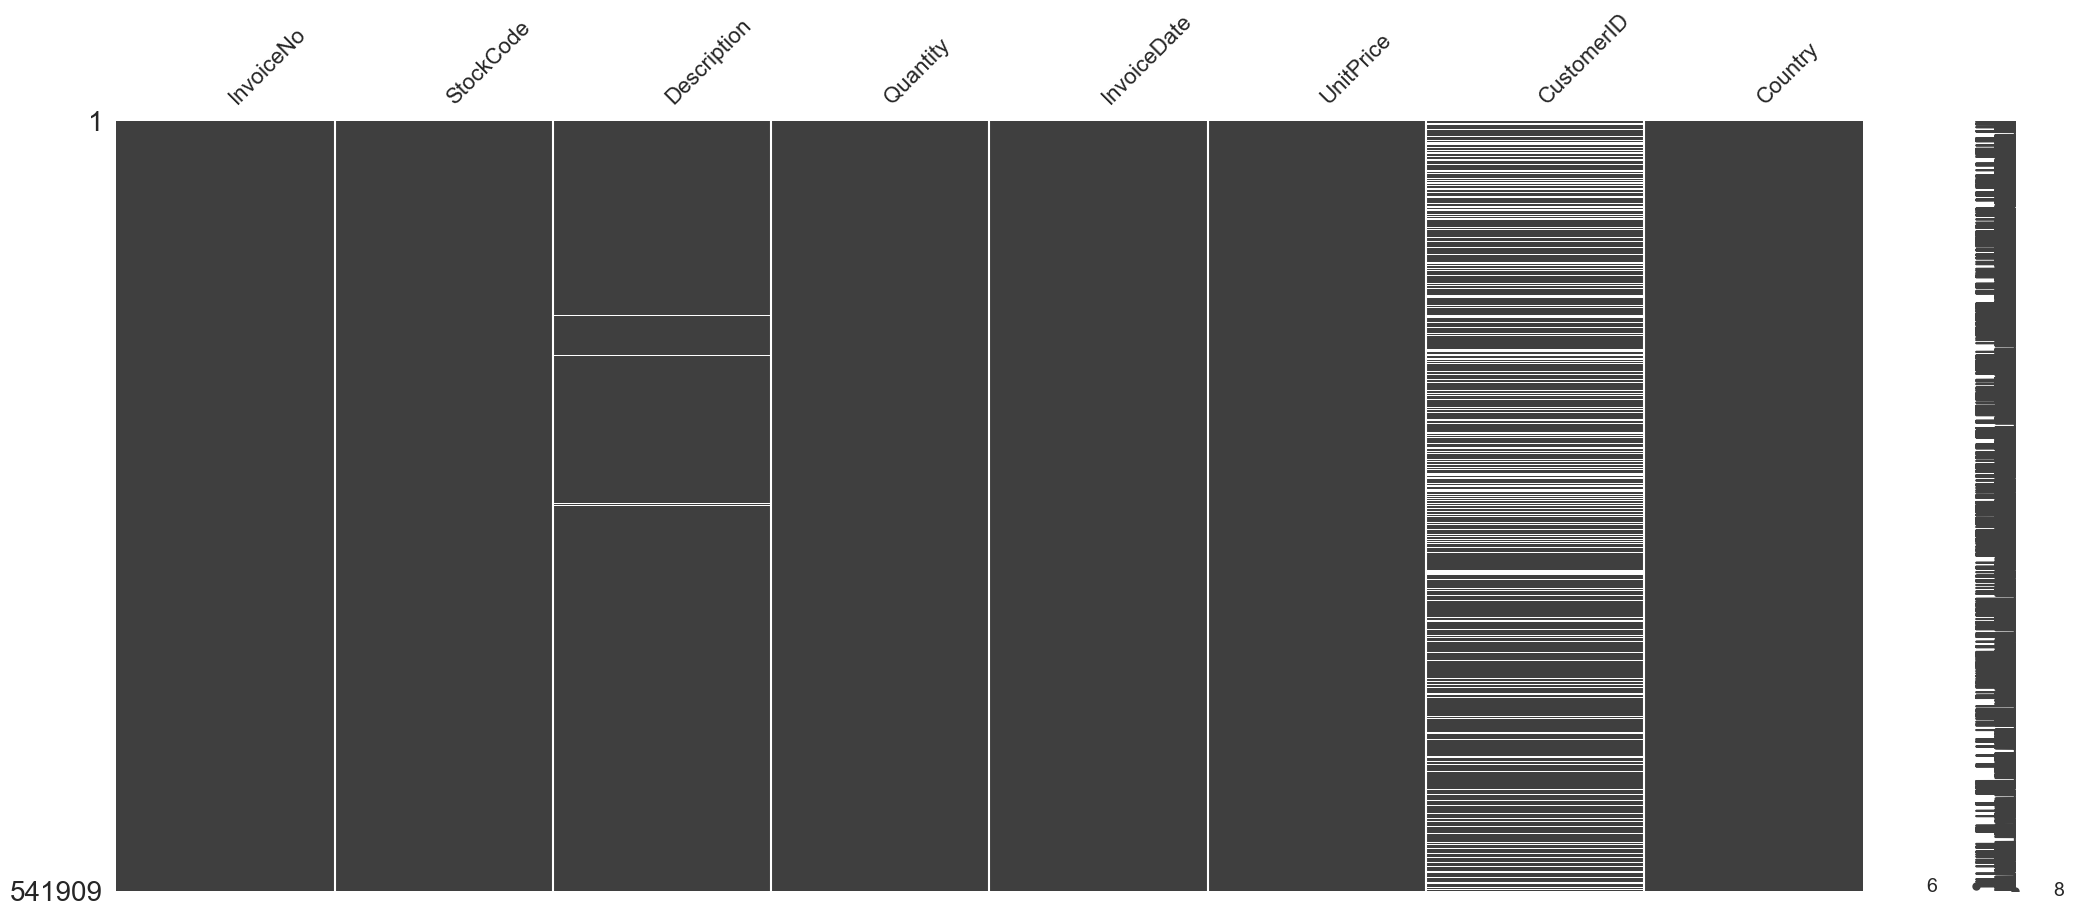

In [13]:
msno.matrix(df)

In [14]:
df = df.dropna(subset=['CustomerID', 'Description'])

### Handling Duplicates

In [15]:
duplicate_rows_sorted = df[df.duplicated(keep=False)].sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])

In [16]:
duplicate_rows_sorted.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom


In [17]:
print(f"The dataset contains {df.duplicated().sum()} duplicate rows that need to be removed.")
df = df.drop_duplicates()

The dataset contains 5225 duplicate rows that need to be removed.


In [18]:
df.shape

(401604, 8)

### Treating Cancelled Transactions

In [19]:
df['Transaction_Status'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

In [20]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction_Status
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,Completed
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Completed
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,Completed
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Completed
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Completed


In [21]:
df.groupby('StockCode')['CustomerID'].sum().sort_values(ascending=False)

StockCode
85123A    32133017.0
22423     28304447.0
85099B    25348589.0
47566     21665575.0
84879     21400078.0
             ...    
84569C       12748.0
84614A       12725.0
90037B       12662.0
84963A       12567.0
20957        12472.0
Name: CustomerID, Length: 3684, dtype: float64

In [22]:
df.groupby('StockCode')['Description'].count().sort_values(ascending=False)

StockCode
85123A    2065
22423     1894
85099B    1659
47566     1409
84879     1405
          ... 
90176B       1
90176C       1
90069        1
90035C       1
37461        1
Name: Description, Length: 3684, dtype: int64

In [23]:
df['Transaction_Status'].value_counts()

Transaction_Status
Completed    392732
Cancelled      8872
Name: count, dtype: int64

In [24]:
# Analyze the characteristics of these rows (considering the new column)
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancelled_transactions.describe().drop('CustomerID', axis=1)

,Quantity,UnitPrice
count,8872.000000,8872.000000
mean,-30.774910,18.899512
std,1172.249902,445.190864
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,4.950000
max,-1.000000,38970.000000


### Correcting StockCode Anomalies

In [25]:
topten_stockcode_df = df['StockCode'].value_counts(normalize=True).head(10) * 100

In [26]:
topten_stockcode_df

StockCode
85123A    0.514188
22423     0.471609
85099B    0.413093
47566     0.350843
84879     0.349847
20725     0.335156
22720     0.304778
POST      0.297806
22197     0.276392
23203     0.275894
Name: proportion, dtype: float64

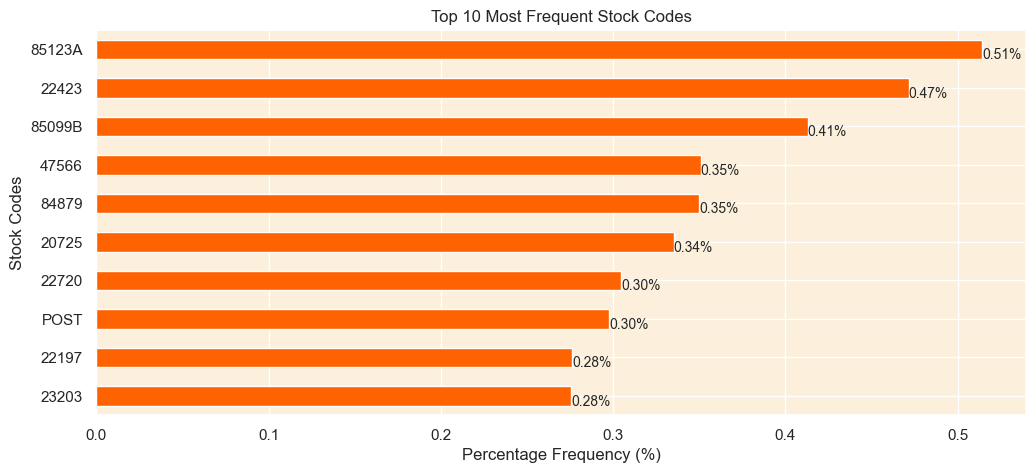

In [27]:
plt.figure(figsize=(12, 5))
topten_stockcode_df.plot(kind='barh', color='#ff6200')

# Adding the percentage frequency on the bars
for index, value in enumerate(topten_stockcode_df):
    plt.text(value, index+0.25, f'{value:.2f}%', fontsize=10)

plt.title('Top 10 Most Frequent Stock Codes')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Stock Codes')
plt.gca().invert_yaxis()
plt.show()

In [28]:
df[df['StockCode'] == 'POST'].shape[0]

1196

In [29]:
unique_stockcode = df['StockCode'].unique()

In [30]:
pd.Series(unique_stockcode).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

5    3676
0       7
1       1
Name: count, dtype: int64

<p> Inference:
The output indicates the following:

A majority of the unique stock codes (3676 out of 3684) contain exactly 5 numeric characters, which seems to be the standard format for representing product codes in this dataset.
There are a few anomalies: 7 stock codes contain no numeric characters and 1 stock code contains only 1 numeric character. These are clearly deviating from the standard format and need further investigation to understand their nature and whether they represent valid product transactions.
Now, let's identify the stock codes that contain 0 or 1 numeric characters to further understand these anomalies:</p>

In [31]:
unique_stockcode

array(['85123A', '71053', '84406B', ..., '90214Z', '90089', '23843'],
      dtype=object)

In [32]:
anomalous_stock_codes =[code for code in unique_stockcode if sum(c.isdigit() for c in str(code)) in (0,1)]

In [33]:
anomalous_stock_codes

['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK']

In [34]:
df['StockCode'].isin(anomalous_stock_codes).sum() / df.shape[0] * 100

0.4768378801007958

In [35]:
df = df[~df['StockCode'].isin(anomalous_stock_codes)]

In [36]:
df.shape

(399689, 9)

### Cleaning Description Column

In [37]:
top_30_descriptions = df['Description'].value_counts()[:30][::-1]

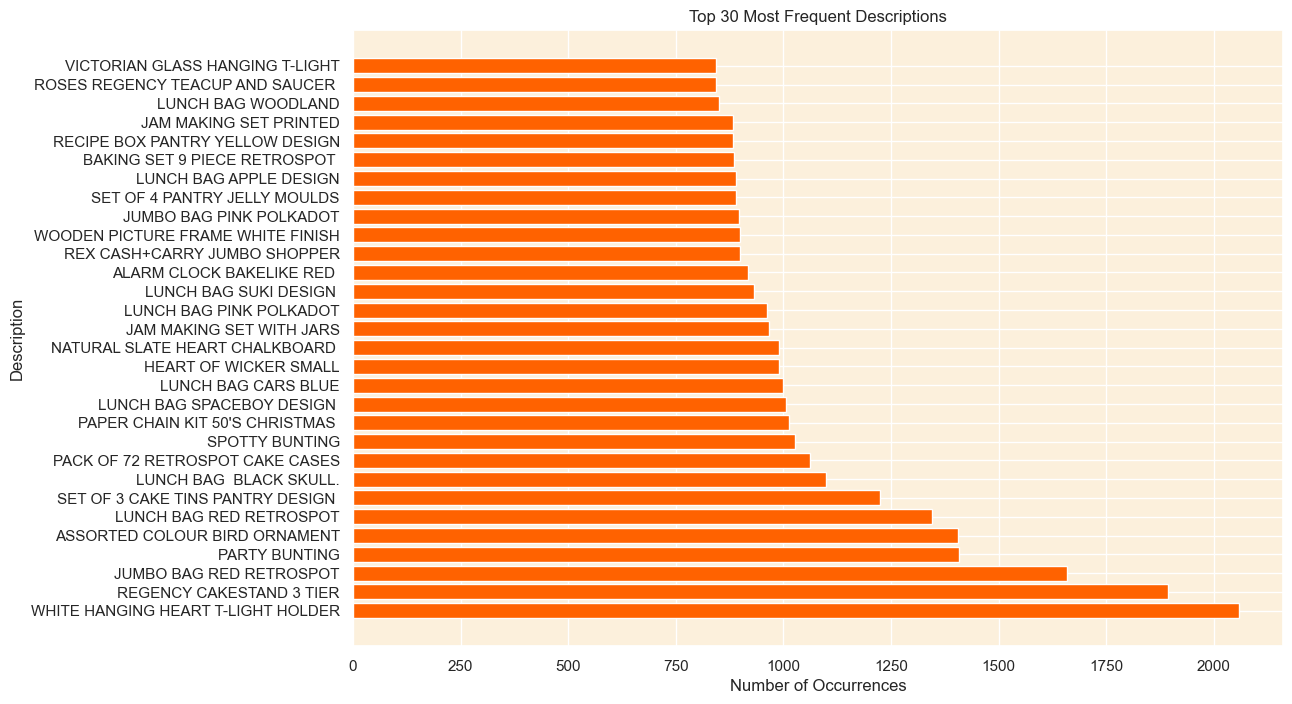

In [38]:
plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions[::-1].index, top_30_descriptions[::-1].values, color='#ff6200') 

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')

# Show the plot
plt.show()

In [39]:
lowercase_descriptions = [item for item in df['Description'].unique() if any(char.islower() for char in item)]

In [40]:
lowercase_descriptions

['BAG 500g SWIRLY MARBLES',
 'POLYESTER FILLER PAD 45x45cm',
 'POLYESTER FILLER PAD 45x30cm',
 'POLYESTER FILLER PAD 40x40cm',
 'FRENCH BLUE METAL DOOR SIGN No',
 'BAG 250g SWIRLY MARBLES',
 'BAG 125g SWIRLY MARBLES',
 '3 TRADITIONAl BISCUIT CUTTERS  SET',
 'NUMBER TILE COTTAGE GARDEN No',
 'FOLK ART GREETING CARD,pack/12',
 'ESSENTIAL BALM 3.5g TIN IN ENVELOPE',
 'POLYESTER FILLER PAD 65CMx65CM',
 'NUMBER TILE VINTAGE FONT No ',
 'POLYESTER FILLER PAD 30CMx30CM',
 'POLYESTER FILLER PAD 60x40cm',
 'FLOWERS HANDBAG blue and orange',
 'Next Day Carriage',
 'THE KING GIFT BAG 25x24x12cm',
 'High Resolution Image']

In [41]:
service_related_descriptions = ["Next Day Carriage", "High Resolution Image"]

In [42]:
# df[(df['Description'] == "Next Day Carriage") | (df['Description'] == "High Resolution Image")].shape[0]
df['Description'].isin(service_related_descriptions).sum()

83

In [43]:
df = df[~df['Description'].isin(service_related_descriptions)]

In [44]:
df['Description'] = df['Description'].str.upper()

### Treating Zero Unit Prices

In [45]:
df['UnitPrice'].describe()

count    399606.000000
mean          2.904957
std           4.448796
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

In [46]:
df[df['UnitPrice'] == 0].describe()[['Quantity']]

,Quantity
count,33.000000
mean,420.515152
std,2176.713608
min,1.000000
25%,2.000000
50%,11.000000
75%,36.000000
max,12540.000000


In [47]:
df = df[df['UnitPrice'] > 0]

In [48]:
df.reset_index(drop=True, inplace=True)

In [49]:
df.shape

(399573, 9)

### Outlier Treatment

<p> In K-means clustering, the algorithm is sensitive to both the scale of data and the presence of outliers, as they can significantly influence the position of centroids, potentially leading to incorrect cluster assignments. However, considering the context of this project where the final goal is to understand customer behavior and preferences through K-means clustering, it would be more prudent to address the issue of outliers after the feature engineering phase where we create a customer-centric dataset. At this stage, the data is transactional, and removing outliers might eliminate valuable information that could play a crucial role in segmenting customers later on. Therefore, we will postpone the outlier treatment and proceed to the next stage for now.</p>

### Feature Engineering
### RFM Features

### Recency (R)

In [50]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Transaction_Status'],
      dtype='object')

In [51]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [52]:
df['InvoiceDay'] = df['InvoiceDate'].dt.date

In [53]:
customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()

In [54]:
most_recent_date = df['InvoiceDay'].max()

In [55]:
most_recent_date

datetime.date(2011, 12, 9)

In [56]:
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])

In [57]:
most_recent_date = pd.to_datetime(most_recent_date)

In [58]:
customer_data['InvoiceDay']

0      2011-01-18
1      2011-12-07
2      2011-09-25
3      2011-11-21
4      2011-02-02
          ...    
4357   2011-03-07
4358   2011-06-12
4359   2011-12-02
4360   2011-12-06
4361   2011-10-28
Name: InvoiceDay, Length: 4362, dtype: datetime64[ns]

In [59]:
most_recent_date - customer_data['InvoiceDay']

0      325 days
1        2 days
2       75 days
3       18 days
4      310 days
         ...   
4357   277 days
4358   180 days
4359     7 days
4360     3 days
4361    42 days
Name: InvoiceDay, Length: 4362, dtype: timedelta64[ns]

In [60]:
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

In [61]:
customer_data['Days_Since_Last_Purchase']

0       325
1         2
2        75
3        18
4       310
       ... 
4357    277
4358    180
4359      7
4360      3
4361     42
Name: Days_Since_Last_Purchase, Length: 4362, dtype: int64

In [62]:
customer_data.drop(columns=['InvoiceDay'], inplace=True)

In [63]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


### Frequency (F)

In [64]:
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True)

In [65]:
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction_Status,InvoiceDay
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,Completed,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Completed,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,Completed,2010-12-01


In [66]:
total_products_purchased = df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

In [67]:
customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')

In [68]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,12346.0,325,2,0
1,12347.0,2,7,2458
2,12348.0,75,4,2332
3,12349.0,18,1,630
4,12350.0,310,1,196


### Monetary (M)

In [69]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Transaction_Status',
       'InvoiceDay'],
      dtype='object')

In [70]:
df['Total_Spend'] = df['UnitPrice'] * df['Quantity']

In [71]:
total_spend = df.groupby('CustomerID')['Total_Spend'].sum().reset_index()

In [72]:
average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')

In [73]:
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

In [74]:
customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

In [75]:
customer_data

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,12346.0,325,2,0,0.00,0.000000
1,12347.0,2,7,2458,4310.00,615.714286
2,12348.0,75,4,2332,1437.24,359.310000
3,12349.0,18,1,630,1457.55,1457.550000
4,12350.0,310,1,196,294.40,294.400000
...,...,...,...,...,...,...
4357,18280.0,277,1,45,180.60,180.600000
4358,18281.0,180,1,54,80.82,80.820000
4359,18282.0,7,3,98,176.60,58.866667
4360,18283.0,3,16,1355,2039.58,127.473750


### Product Diversity

In [76]:
unique_products_purchased = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

In [77]:
customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerID')

In [78]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,12346.0,325,2,0,0.00,0.000000,1
1,12347.0,2,7,2458,4310.00,615.714286,103
2,12348.0,75,4,2332,1437.24,359.310000,21
3,12349.0,18,1,630,1457.55,1457.550000,72
4,12350.0,310,1,196,294.40,294.400000,16


### Behavioral Features

In [79]:
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# Calculate the average number of days between consecutive purchases
days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

# Find the favorite shopping day of the week
favorite_shopping_day = df.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

# Find the favorite shopping hour of the day
favorite_shopping_hour = df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16


### Geographic Features

In [80]:
df['Country'].value_counts(normalize=True).head()

Country
United Kingdom    0.890971
Germany           0.022722
France            0.020402
EIRE              0.018440
Spain             0.006162
Name: proportion, dtype: float64

In [81]:
customer_country = df.groupby(['CustomerID', 'Country']).size().reset_index(name='Number_of_Transactions')

In [82]:
customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('CustomerID')

# Create a binary column indicating whether the customer is from the UK or not
customer_main_country['Is_UK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

# Merge this data with our customer_data dataframe
customer_data = pd.merge(customer_data, customer_main_country[['CustomerID', 'Is_UK']], on='CustomerID', how='left')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0


In [83]:
customer_data['Is_UK'].value_counts()

Is_UK
1    3866
0     416
Name: count, dtype: int64

### Cancellation Insights

In [84]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

# Calculate the number of cancelled transactions for each customer
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancellation_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_frequency.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)

# Merge the Cancellation Frequency data into the customer_data dataframe
customer_data = pd.merge(customer_data, cancellation_frequency, on='CustomerID', how='left')

# Replace NaN values with 0 (for customers who have not cancelled any transaction)
customer_data['Cancellation_Frequency'].fillna(0, inplace=True)

# Calculate the Cancellation Rate
customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['InvoiceNo']

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0


### Seasonality & Trends

In [85]:
# Extract month and year from InvoiceDate
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

# Calculate monthly spending for each customer
monthly_spending = df.groupby(['CustomerID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

# Calculate Seasonal Buying Patterns: We are using monthly frequency as a proxy for seasonal buying patterns
seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

# Replace NaN values in Monthly_Spending_Std with 0, implying no variability for customers with single transaction month
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

# Calculate Trends in Spending 
# We are using the slope of the linear trend line fitted to the customer's spending over time as an indicator of spending trends
def calculate_trend(spend_data):
    # If there are more than one data points, we calculate the trend using linear regression
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    # If there is only one data point, no trend can be calculated, hence we return 0
    else:
        return 0

# Apply the calculate_trend function to find the spending trend for each customer
spending_trends = monthly_spending.groupby('CustomerID')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.concat([customer_data, seasonal_buying_patterns], axis=1)
customer_data = pd.concat([customer_data, spending_trends], axis=1)

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,CustomerID,Monthly_Spending_Mean,Monthly_Spending_Std,CustomerID,Spending_Trend
0,12346.0,325.0,2.0,0.0,0.00,0.000000,1.0,0.000000,1.0,10.0,1.0,1.0,0.5,12346.0,0.000000,0.000000,12346.0,0.000000
1,12347.0,2.0,7.0,2458.0,4310.00,615.714286,103.0,2.016575,1.0,14.0,0.0,0.0,0.0,12347.0,615.714286,341.070789,12347.0,4.486071
2,12348.0,75.0,4.0,2332.0,1437.24,359.310000,21.0,10.884615,3.0,19.0,0.0,0.0,0.0,12348.0,359.310000,203.875689,12348.0,-100.884000
3,12349.0,18.0,1.0,630.0,1457.55,1457.550000,72.0,0.000000,0.0,9.0,0.0,0.0,0.0,12349.0,1457.550000,0.000000,12349.0,0.000000
4,12350.0,310.0,1.0,196.0,294.40,294.400000,16.0,0.000000,2.0,16.0,0.0,0.0,0.0,12350.0,294.400000,0.000000,12350.0,0.000000


In [86]:
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)

# Convert data types of columns to optimal types
customer_data = customer_data.convert_dtypes()

In [87]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4362 entries, 0 to 4361
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      4362 non-null   string 
 1   Days_Since_Last_Purchase        4282 non-null   Int64  
 2   Total_Transactions              4282 non-null   Int64  
 3   Total_Products_Purchased        4282 non-null   Int64  
 4   Total_Spend                     4282 non-null   Float64
 5   Average_Transaction_Value       4282 non-null   Float64
 6   Unique_Products_Purchased       4282 non-null   Int64  
 7   Average_Days_Between_Purchases  4282 non-null   Float64
 8   Day_Of_Week                     4282 non-null   Int64  
 9   Hour                            4282 non-null   Int64  
 10  Is_UK                           4282 non-null   Int64  
 11  Cancellation_Frequency          4282 non-null   Int64  
 12  Cancellation_Rate               42

### Outlier Detection and Treatment

In [88]:
from sklearn.ensemble import IsolationForest

In [89]:
customer_data.head(2)

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,CustomerID,Monthly_Spending_Mean,Monthly_Spending_Std,CustomerID,Spending_Trend
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,12346.0,0.0,0.0,12346.0,0.0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,12347.0,615.714286,341.070789,12347.0,4.486071


In [90]:
customer_data.dropna(inplace=True)

In [91]:
X = customer_data.iloc[:, 1:].to_numpy()
model = IsolationForest(contamination=0.1)
customer_data['Outlier_Scores'] = model.fit_predict(X)

In [92]:
customer_data.head(2)

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,CustomerID,Monthly_Spending_Mean,Monthly_Spending_Std,CustomerID,Spending_Trend,Outlier_Scores
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,12346.0,0.0,0.0,12346.0,0.0,1
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,12347.0,615.714286,341.070789,12347.0,4.486071,-1


In [93]:
customer_data['Is_Outlier'] = [1 if item == -1 else 0 for item in customer_data['Outlier_Scores']]

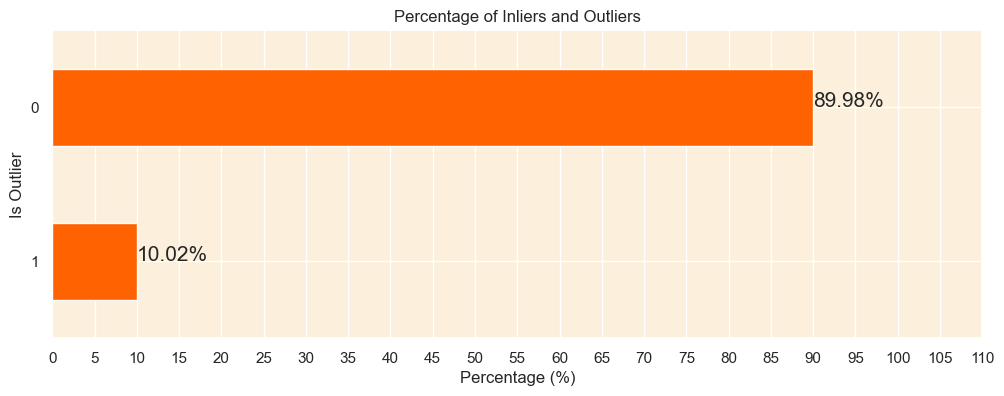

In [94]:
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

# Plotting the percentage of inliers and outliers
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#ff6200')

# Adding the percentage labels on the bars
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

In [164]:
# Separate the outliers for analysis
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

# Remove the outliers from the main dataset
customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

# Reset the index of the cleaned data
customer_data_cleaned.reset_index(drop=True, inplace=True)

In [165]:
customer_data_cleaned.shape

(3853, 18)

### Correlation Analysis

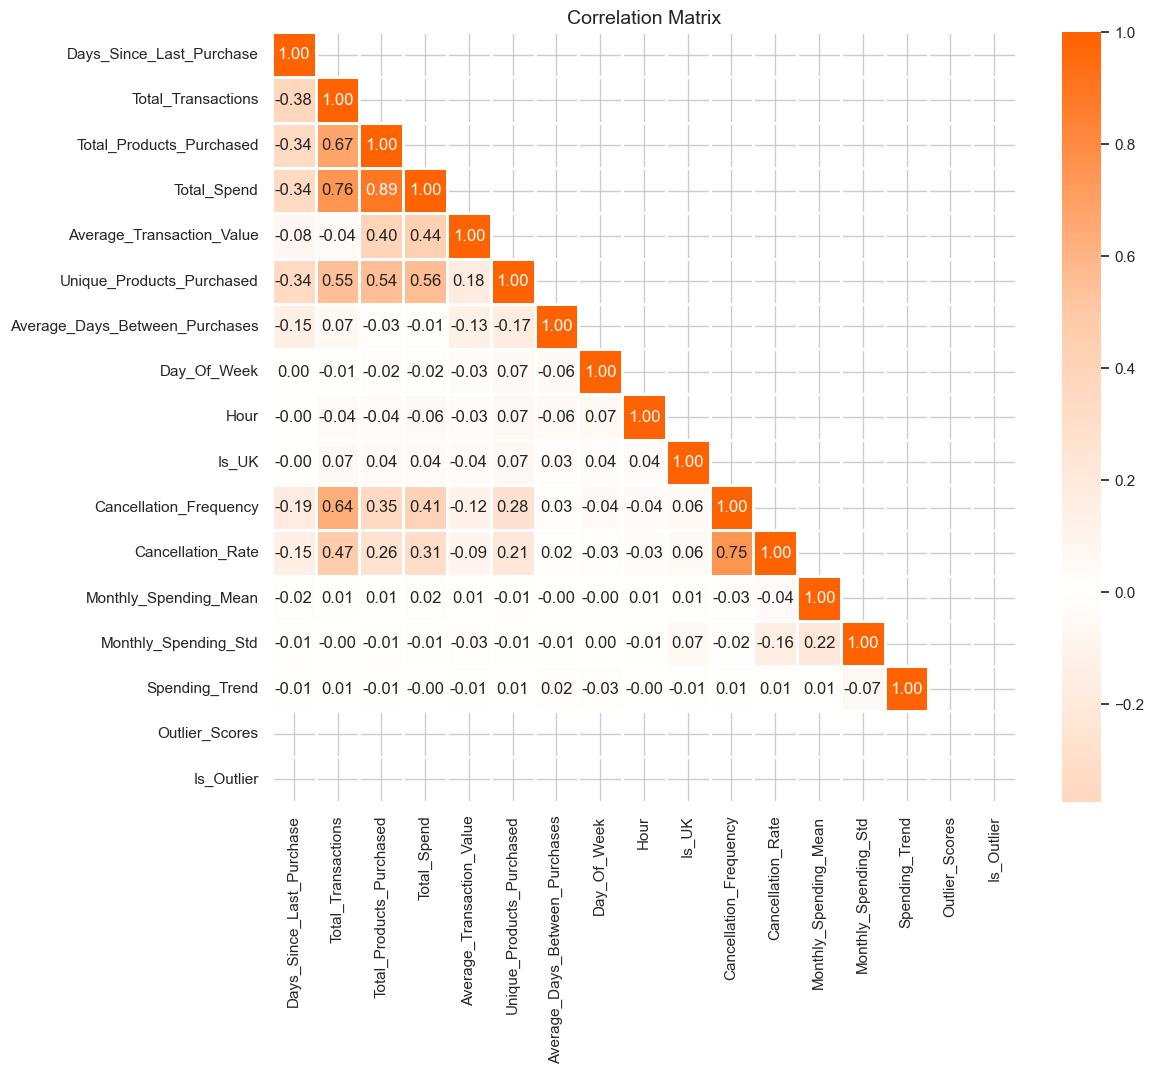

In [98]:
# Reset background style
sns.set_style('whitegrid')

# Calculate the correlation matrix excluding the 'CustomerID' column
corr = customer_data_cleaned.drop(columns=['CustomerID']).corr()

# Define a custom colormap
colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its 
# top-left to bottom-right diagonal)

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

### Feature Scaling

In [99]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['CustomerID', 'Is_UK', 'Day_Of_Week', 'Is_Outlier']

# List of columns that need to be scaled
columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_data_scaled = customer_data_cleaned.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data
customer_data_scaled.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,CustomerID,Monthly_Spending_Mean,Monthly_Spending_Std,CustomerID,Spending_Trend,Outlier_Scores,Is_Outlier
0,12346.0,2.334400,-0.479849,-0.803710,-0.843224,-1.276213,-0.934114,-0.536625,1,-1.108799,1,0.499187,0.453593,12346.0,-0.517361,-0.635301,12346.0,0.072401,0.0,0
4,12350.0,2.183428,-0.746793,-0.551662,-0.604929,0.046114,-0.663403,-0.536625,2,1.509774,0,-0.530453,-0.427028,12350.0,-0.118365,-0.635301,12350.0,0.072401,0.0,0
5,12352.0,-0.574319,1.121818,-0.208312,0.181033,-0.565749,0.076541,0.072889,1,0.636917,0,0.499187,-0.206873,12352.0,-0.088613,0.013463,12352.0,0.126941,0.0,0
6,12353.0,1.116563,-0.746793,-0.777991,-0.771185,-0.876461,-0.879972,-0.536625,3,1.946203,0,-0.530453,-0.427028,12353.0,-0.396741,-0.635301,12353.0,0.072401,0.0,0
8,12355.0,1.217210,-0.746793,-0.495080,-0.471373,0.787228,-0.717545,-0.536625,0,0.200488,0,-0.530453,-0.427028,12355.0,0.105257,-0.635301,12355.0,0.072401,0.0,0


### Dimensionality Reduction

In [100]:
customer_data_scaled.set_index('CustomerID', inplace=True)

In [101]:
pca = PCA()
pca.fit(customer_data_scaled)

PCA()

In [102]:
# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

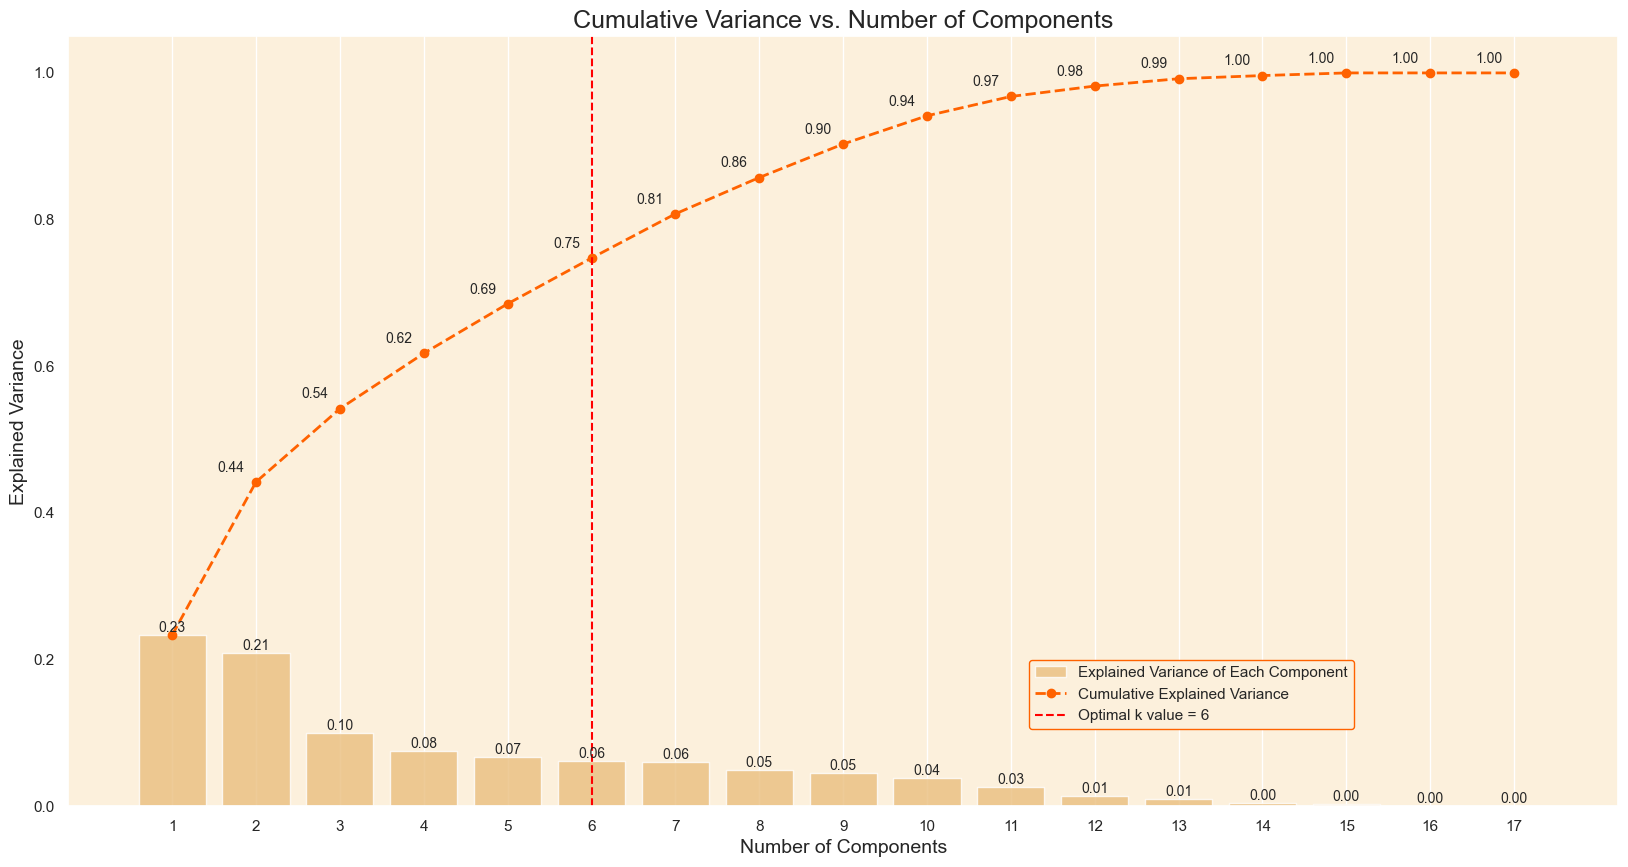

In [103]:
# Set the optimal k value (based on our analysis, we can choose 6)
optimal_k = 6

# Set seaborn plot style
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)

# Plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}') 

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,  
           edgecolor='#ff6200')  

# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')   
plt.show()

In [106]:
# Creating a PCA object with 6 components
pca = PCA(n_components=6)

# Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_data_scaled)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = customer_data_scaled.index

In [107]:
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
CustomerID,,,,,,
"(12346.0, 12346.0, 12346.0)",-1.449990,-1.848743,-1.778091,-0.970219,-0.909630,1.482992
"(12350.0, 12350.0, 12350.0)",-1.869007,-0.721834,0.164938,-1.096341,-1.420562,-0.505509
"(12352.0, 12352.0, 12352.0)",0.868211,-1.413836,-0.531934,0.290134,-0.118932,-0.907288
"(12353.0, 12353.0, 12353.0)",-2.114271,0.282785,-0.495583,-0.883535,-1.147068,-1.250783
"(12355.0, 12355.0, 12355.0)",-1.177141,-2.720532,0.717580,-0.919016,-0.674573,0.223372


In [108]:
# Define a function to highlight the top 3 absolute values in each column of a dataframe
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #ffeacc' if i in top3 else '' for i in column.index]

# Create the PCA component DataFrame and apply the highlighting function
pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],  
                     index=customer_data_scaled.columns)

pc_df.style.apply(highlight_top3, axis=0)

,PC1,PC2,PC3,PC4,PC5,PC6
Days_Since_Last_Purchase,-0.244874,-0.037073,-0.045249,-0.168430,-0.357096,0.314530
Total_Transactions,0.444037,0.058455,-0.145734,0.109722,0.012476,-0.031051
Total_Products_Purchased,0.430390,0.051306,0.255157,-0.022605,0.060156,0.050409
Total_Spend,0.452474,0.055517,0.228082,-0.019912,0.064016,0.068517
Average_Transaction_Value,0.130207,0.001704,0.567394,-0.215763,0.065540,0.169970
Unique_Products_Purchased,0.341946,0.099668,0.172466,-0.035928,-0.157021,-0.199517
Average_Days_Between_Purchases,0.002531,-0.047055,-0.209715,0.233935,0.729537,-0.109696
Day_Of_Week,-0.127721,0.986759,-0.033862,0.003745,0.059487,0.048235
Hour,-0.028618,0.051386,0.030967,-0.036134,-0.372920,-0.753292
Is_UK,0.007268,0.006262,-0.008177,0.014838,-0.006658,-0.006836


### K-Means Clustering

### Determining the Optimal Number of Clusters

#### Elbow Method¶

In [109]:
# Set plot style, and background color
sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})

# Set the color palette for the plot
sns.set_palette(['#ff6200'])

In [117]:
km = KMeans(init='k-means++', n_init='auto', max_iter=300, random_state=0)

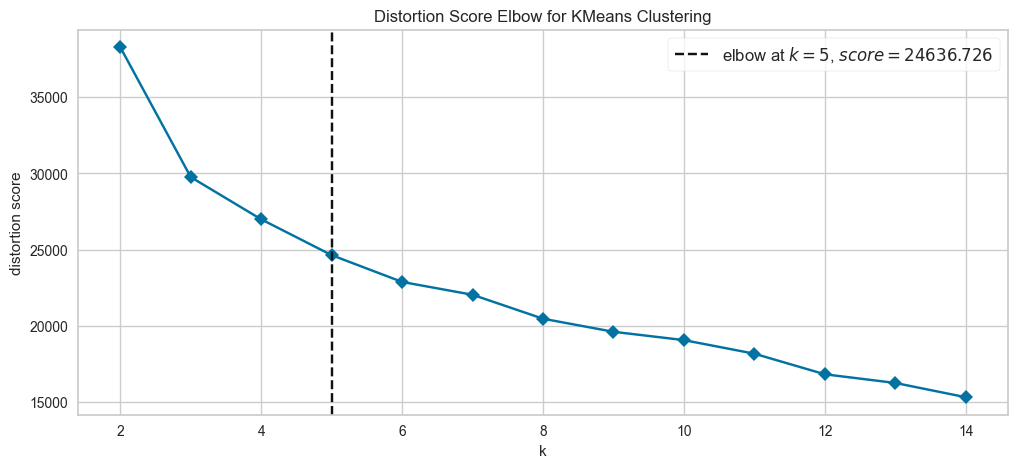

In [118]:
# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 5))

# Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(customer_data_pca)

# Finalize and render the figure
visualizer.show();

### Silhouette Method

In [122]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """

    # Set the size of the figure
    plt.figure(figsize=figsize)

    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    # First plot: Silhouette scores for different k values
    sns.set_palette(['darkorange'])

    silhouette_scores = []

    # Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom', 
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))
             

    # Second plot (subplot): Silhouette plots for each k value
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):    
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        # Assign the plots to the second, third, and fourth rows
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # Add the Silhouette score text to the plot
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

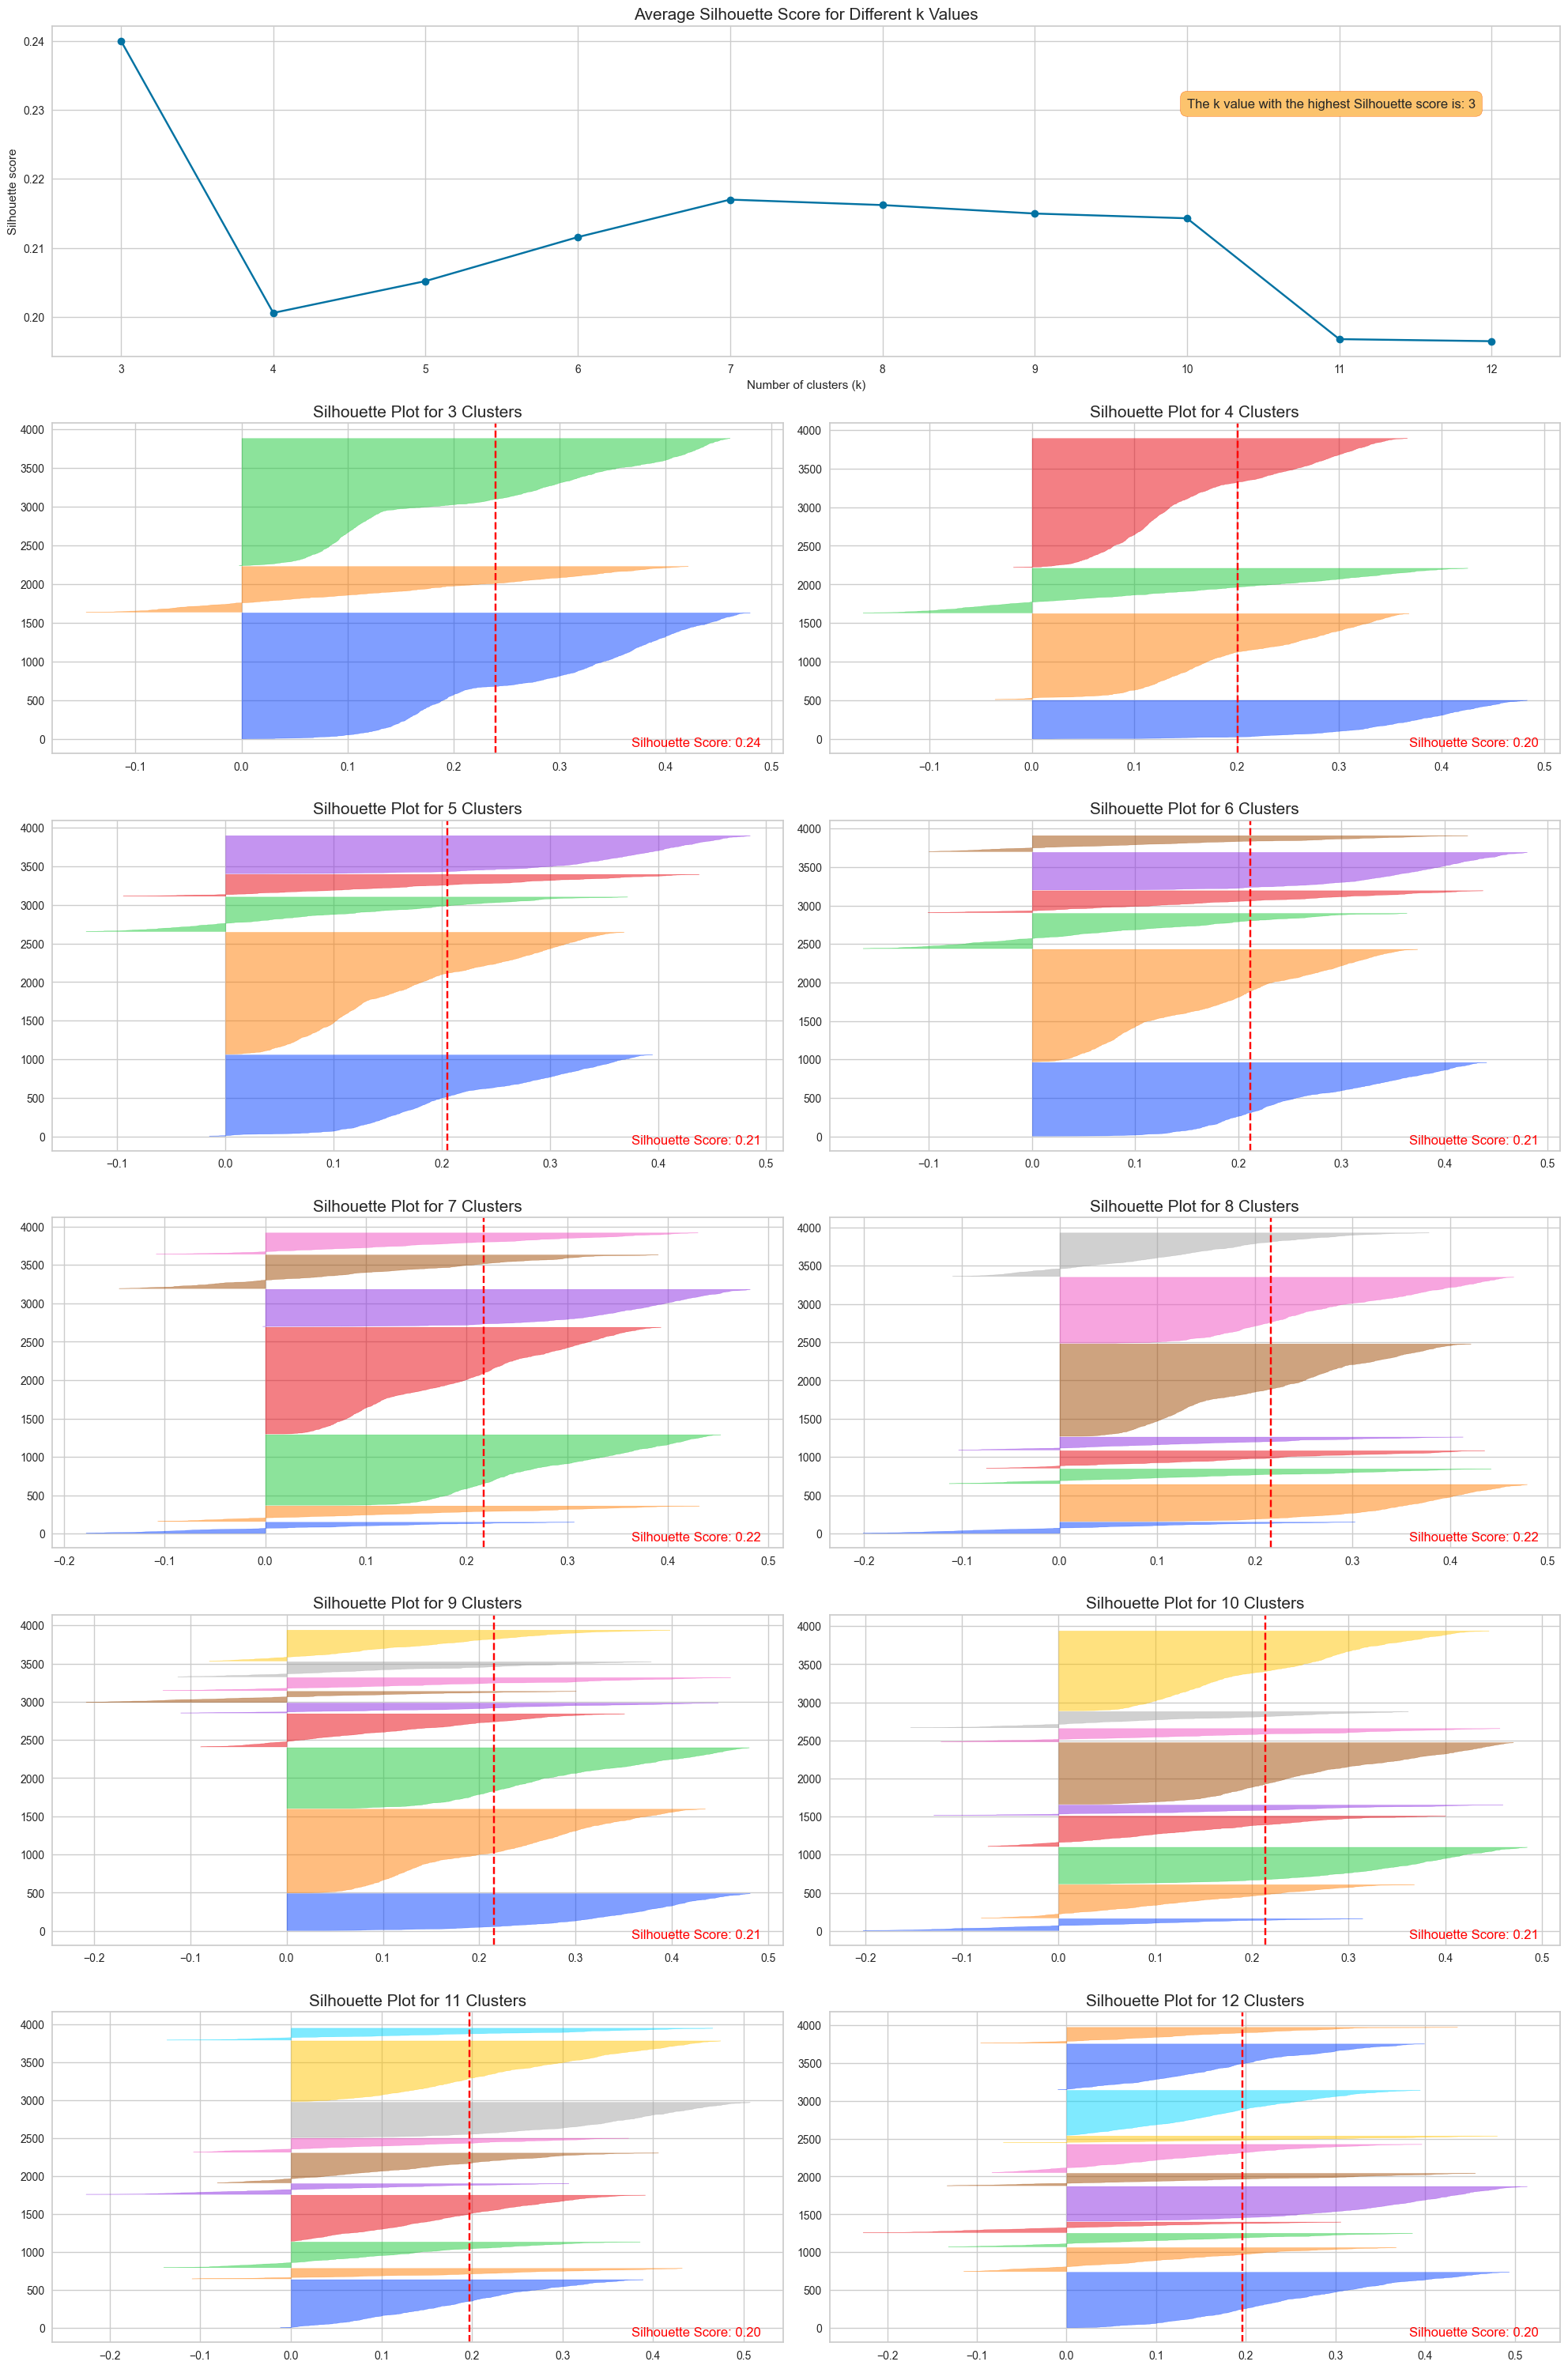

In [123]:
silhouette_analysis(customer_data_pca, 3, 12, figsize=(20, 50))

### Clustering Model - K-means

In [124]:
# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

KMeans(max_iter=100, n_clusters=3, n_init=10, random_state=0)

In [126]:
# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

In [131]:
[new_label for new_label, (label, _) in enumerate(cluster_frequencies.most_common())]

[0, 1, 2]

In [132]:
label_mapping = {label: new_label for new_label, (label, _) in 
                 enumerate(cluster_frequencies.most_common())}

In [133]:
label_mapping

{2: 0, 0: 1, 1: 2}

In [134]:
# Reverse the mapping to assign labels as per your criteria
label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Append the new cluster labels back to the original dataset
customer_data_cleaned['cluster'] = new_labels

# Append the new cluster labels to the PCA version of the dataset
customer_data_pca['cluster'] = new_labels

In [135]:
# Display the first few rows of the original dataframe
customer_data_cleaned.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,...,Cancellation_Frequency,Cancellation_Rate,CustomerID,Monthly_Spending_Mean,Monthly_Spending_Std,CustomerID,Spending_Trend,Outlier_Scores,Is_Outlier,cluster
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,...,1,0.5,12346.0,0.0,0.0,12346.0,0.0,1,0,1
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,...,0,0.0,12350.0,294.4,0.0,12350.0,0.0,1,0,1
5,12352.0,36,8,463,1265.41,158.17625,57,3.13253,1,14,...,1,0.125,12352.0,316.3525,134.700629,12352.0,9.351,1,0,1
6,12353.0,204,1,20,89.0,89.0,4,0.0,3,17,...,0,0.0,12353.0,89.0,0.0,12353.0,0.0,1,0,0
8,12355.0,214,1,240,459.4,459.4,13,0.0,0,13,...,0,0.0,12355.0,459.4,0.0,12355.0,0.0,1,0,1


### Clustering Evaluation

### 3D Visualization of Top Principal Components

In [137]:
colors = ['#e8000b', '#1ac938', '#023eff']

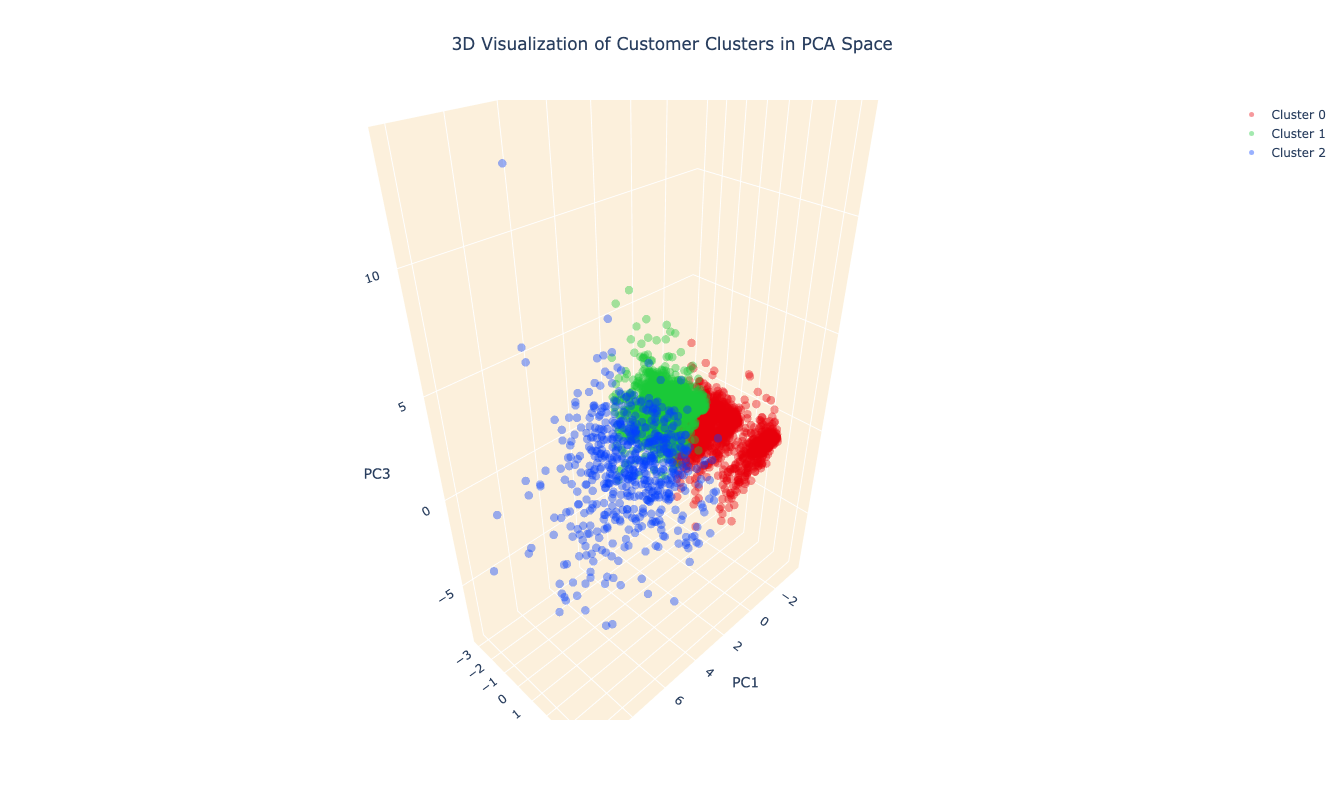

In [140]:
# Create separate data frames for each cluster
cluster_0 = customer_data_pca[customer_data_pca['cluster'] == 0]
cluster_1 = customer_data_pca[customer_data_pca['cluster'] == 1]
cluster_2 = customer_data_pca[customer_data_pca['cluster'] == 2]

# Create a 3D scatter plot
fig = go.Figure()

# Add data points for each cluster separately and specify the color
fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'], 
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'], 
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'], 
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))

# Set the title and layout details
fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

# Show the plot
fig.show()



### Cluster Distribution Visualization¶

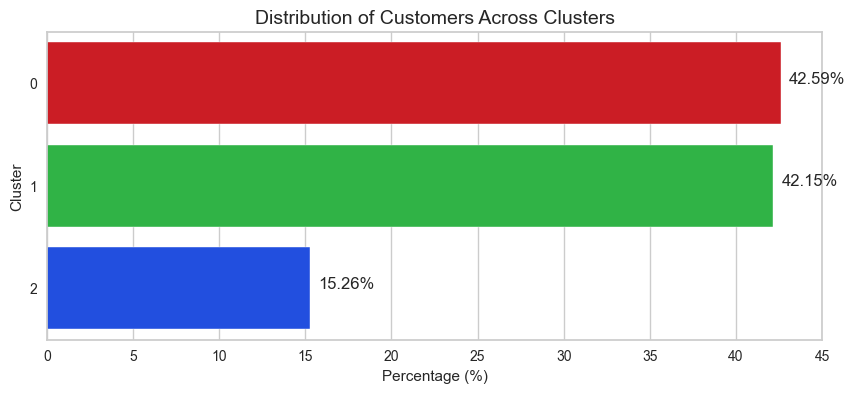

In [141]:
# Calculate the percentage of customers in each cluster
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

### Evaluation Metrics

In [142]:
num_observations = len(customer_data_pca)

In [146]:
X = customer_data_pca.drop('cluster', axis=1)

In [149]:
clusters = customer_data_pca['cluster']

In [150]:
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

In [153]:
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

In [154]:
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+---------------------+
|         Metric          |        Value        |
+-------------------------+---------------------+
| Number of Observations  |        3853         |
|    Silhouette Score     | 0.23998262236026036 |
| Calinski Harabasz Score | 1174.6122345569656  |
|  Davies Bouldin Score   | 1.3762402527186535  |
+-------------------------+---------------------+


### Cluster Analysis and Profiling
### Radar Chart Approach¶

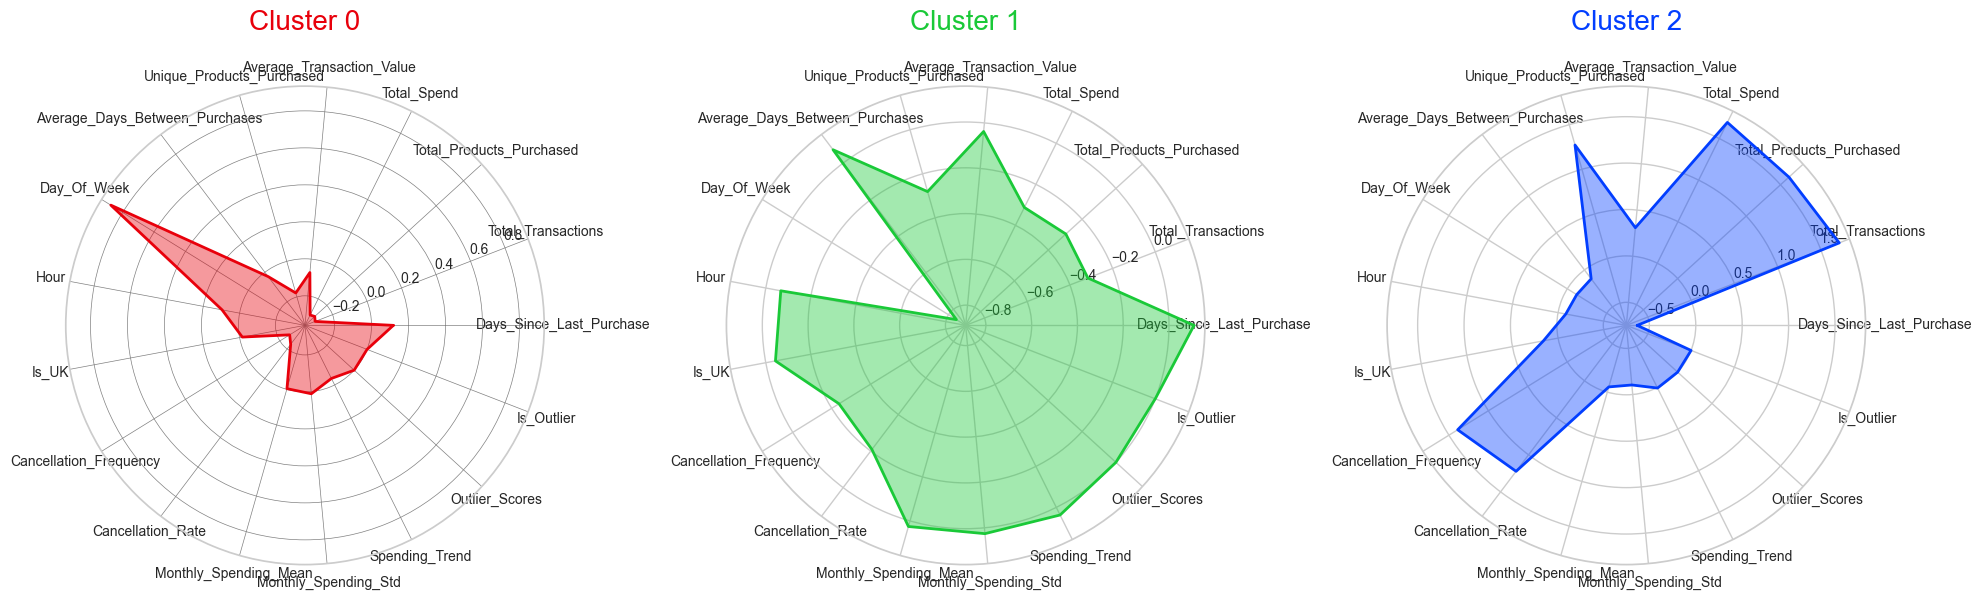

In [155]:
# Setting 'CustomerID' column as index and assigning it to a new dataframe
df_customer = customer_data_cleaned.set_index('CustomerID')

# Standardize the data (excluding the cluster column)
scaler = StandardScaler()
df_customer_standardized = scaler.fit_transform(df_customer.drop(columns=['cluster'], axis=1))

# Create a new dataframe with standardized values and add the cluster column back
df_customer_standardized = pd.DataFrame(df_customer_standardized, columns=df_customer.columns[:-1], index=df_customer.index)
df_customer_standardized['cluster'] = df_customer['cluster']

# Calculate the centroids of each cluster
cluster_centroids = df_customer_standardized.groupby('cluster').mean()

# Function to create a radar chart
def create_radar_chart(ax, angles, data, color, cluster):
    # Plot the data and fill the area
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    
    # Add a title
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

# Set data
labels=np.array(cluster_centroids.columns)
num_vars = len(labels)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop" and append the start to the end
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

# Initialize the figure
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(polar=True), nrows=1, ncols=3)

# Create radar chart for each cluster
for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]  # Complete the loop
    create_radar_chart(ax[i], angles, data, color, i)

# Add input data
ax[0].set_xticks(angles[:-1])
ax[0].set_xticklabels(labels[:-1])

ax[1].set_xticks(angles[:-1])
ax[1].set_xticklabels(labels[:-1])

ax[2].set_xticks(angles[:-1])
ax[2].set_xticklabels(labels[:-1])

# Add a grid
ax[0].grid(color='grey', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()

<p> Customer Profiles Derived from Radar Chart Analysis

    
Cluster 0 (Red Chart):
🎯 Profile: Sporadic Shoppers with a Preference for Weekend Shopping

Customers in this cluster tend to spend less, with a lower number of transactions and products purchased.
They have a slight tendency to shop during the weekends, as indicated by the very high Day_of_Week value.
Their spending trend is relatively stable but on the lower side, and they have a low monthly spending variation (low Monthly_Spending_Std).
These customers have not engaged in many cancellations, showing a low cancellation frequency and rate.
The average transaction value is on the lower side, indicating that when they do shop, they tend to spend less per transaction.


Cluster 1 (Green Chart):
🎯 Profile: Infrequent Big Spenders with a High Spending Trend

Customers in this cluster show a moderate level of spending, but their transactions are not very frequent, as indicated by the high Days_Since_Last_Purchase and Average_Days_Between_Purchases.
They have a very high spending trend, indicating that their spending has been increasing over time.
These customers prefer shopping late in the day, as indicated by the high Hour value, and they mainly reside in the UK.
They have a tendency to cancel a moderate number of transactions, with a medium cancellation frequency and rate.
Their average transaction value is relatively high, meaning that when they shop, they tend to make substantial purchases.



Cluster 2 (Blue Chart):
🎯 Profile: Frequent High-Spenders with a High Rate of Cancellations

Customers in this cluster are high spenders with a very high total spend, and they purchase a wide variety of unique products.
They engage in frequent transactions, but also have a high cancellation frequency and rate.
These customers have a very low average time between purchases, and they tend to shop early in the day (low Hour value).
Their monthly spending shows high variability, indicating that their spending patterns might be less predictable compared to other clusters.
Despite their high spending, they show a low spending trend, suggesting that their high spending levels might be decreasing over time.  </p>

###  Histogram Chart Approach

ValueError: The 'color' keyword argument must have one color per dataset, but 3 datasets and 1 colors were provided

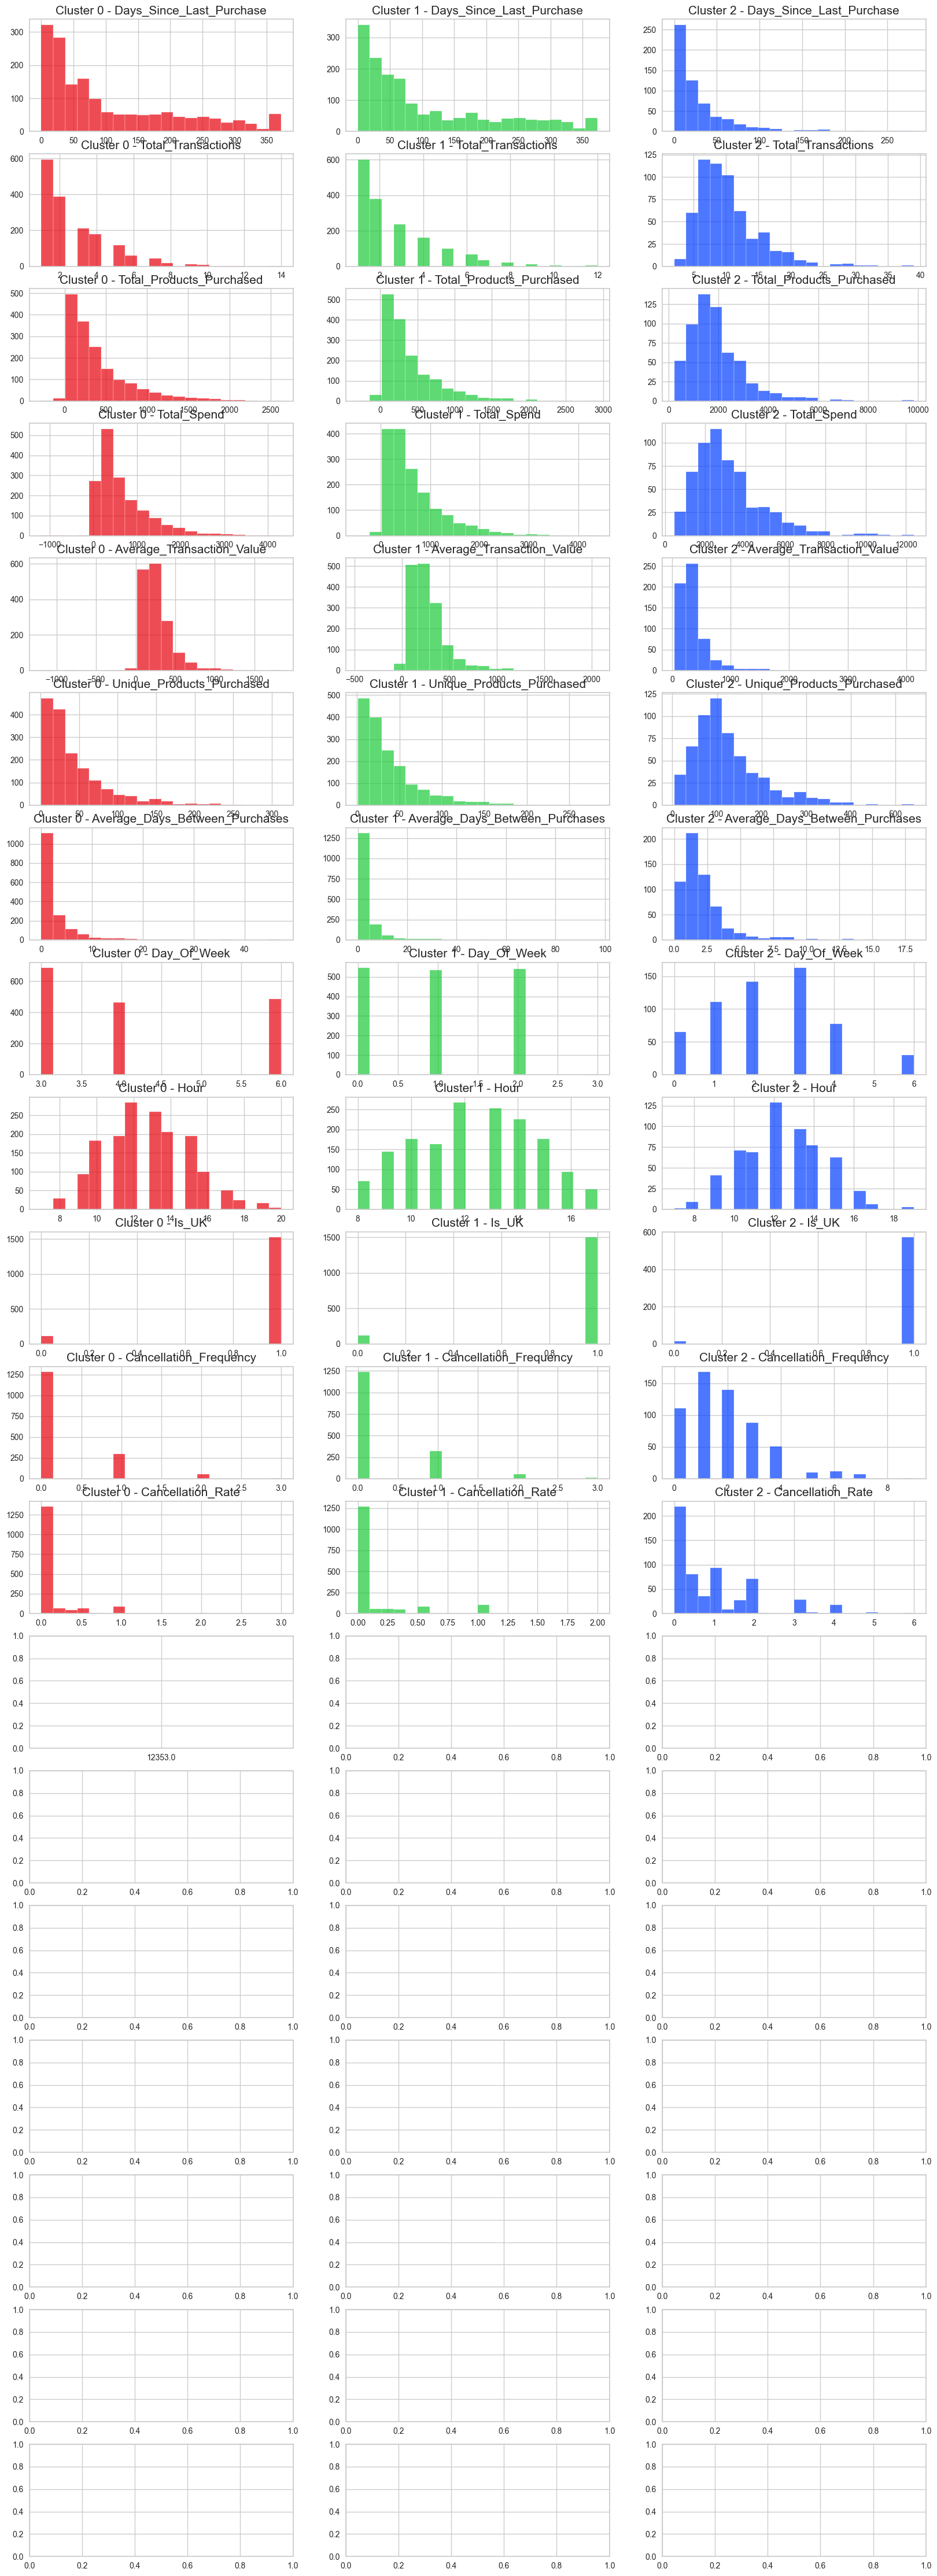

In [156]:
# Plot histograms for each feature segmented by the clusters
features = customer_data_cleaned.columns[1:-1]
clusters = customer_data_cleaned['cluster'].unique()
clusters.sort()

# Setting up the subplots
n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))

# Plotting histograms
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Adjusting layout to prevent overlapping
plt.tight_layout()
plt.show()

### Recommendation System

<p> In the final phase of this project, I am set to develop a recommendation system to enhance the online shopping experience. This system will suggest products to customers based on the purchasing patterns prevalent in their respective clusters. Earlier in the project, during the customer data preparation stage, I isolated a small fraction (5%) of the customers identified as outliers and reserved them in a separate dataset called outliers_data.

Now, focusing on the core 95% of the customer group, I analyze the cleansed customer data to pinpoint the top-selling products within each cluster. Leveraging this information, the system will craft personalized recommendations, suggesting the top three products popular within their cluster that they have not yet purchased. This not only facilitates targeted marketing strategies but also enriches the personal shopping experience, potentially boosting sales. For the outlier group, a basic approach could be to recommend random products, as a starting point to engage them. </p>

In [169]:
# Step 1: Extract the CustomerIDs of the outliers and remove their transactions from the main dataframe
outlier_customer_ids = outliers_data['CustomerID'].astype('float').unique()
df_filtered = df[~df['CustomerID'].isin(outlier_customer_ids)]

# Step 2: Ensure consistent data type for CustomerID across both dataframes before merging
customer_data_cleaned['CustomerID'] = customer_data_cleaned['CustomerID'].astype('float')

# Step 3: Merge the transaction data with the customer data to get the cluster information for each transaction
merged_data = df_filtered.merge(customer_data_cleaned[['CustomerID', 'cluster']], on='CustomerID', how='inner')

# Step 4: Identify the top 10 best-selling products in each cluster based on the total quantity sold
best_selling_products = merged_data.groupby(['cluster', 'StockCode', 'Description'])['Quantity'].sum().reset_index()
best_selling_products = best_selling_products.sort_values(by=['cluster', 'Quantity'], ascending=[True, False])
top_products_per_cluster = best_selling_products.groupby('cluster').head(10)

# Step 5: Create a record of products purchased by each customer in each cluster
customer_purchases = merged_data.groupby(['CustomerID', 'cluster', 'StockCode'])['Quantity'].sum().reset_index()

# Step 6: Generate recommendations for each customer in each cluster
recommendations = []
for cluster in top_products_per_cluster['cluster'].unique():
    top_products = top_products_per_cluster[top_products_per_cluster['cluster'] == cluster]
    customers_in_cluster = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster]['CustomerID']
    
    for customer in customers_in_cluster:
        # Identify products already purchased by the customer
        customer_purchased_products = customer_purchases[(customer_purchases['CustomerID'] == customer) & 
                                                         (customer_purchases['cluster'] == cluster)]['StockCode'].tolist()
        
        # Find top 3 products in the best-selling list that the customer hasn't purchased yet
        top_products_not_purchased = top_products[~top_products['StockCode'].isin(customer_purchased_products)]
        top_3_products_not_purchased = top_products_not_purchased.head(3)
        
        # Append the recommendations to the list
        recommendations.append([customer, cluster] + top_3_products_not_purchased[['StockCode', 'Description']].values.flatten().tolist())

# Step 7: Create a dataframe from the recommendations list and merge it with the original customer data
recommendations_df = pd.DataFrame(recommendations, columns=['CustomerID', 'cluster', 'Rec1_StockCode', 'Rec1_Description', \
                                                 'Rec2_StockCode', 'Rec2_Description', 'Rec3_StockCode', 'Rec3_Description'])
customer_data_with_recommendations = customer_data_cleaned.merge(recommendations_df, on=['CustomerID', 'cluster'], how='right')

AttributeError: 'DataFrame' object has no attribute 'unique'

In [168]:
customer_data_with_recommendations.set_index('CustomerID').iloc[:, -6:].sample(10, random_state=0)